<a href="https://colab.research.google.com/github/Akhila981010/project1/blob/main/Alziemer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

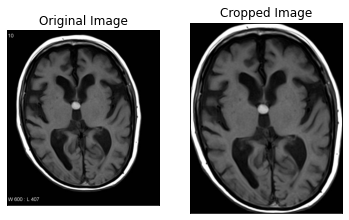

In [4]:
ex_img = cv2.imread('/content/drive/My Drive/AD/YES/Y6.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            
#             print(directory + '/' + filename)
            
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_path = '/content/drive/My Drive/AD/augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

print(augmented_yes)
print(augmented_no)

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

/content/drive/My Drive/AD/augmented_data/yes
/content/drive/My Drive/AD/augmented_data/no
Number of examples is: 380
X shape is: (380, 240, 240, 3)
y shape is: (380, 1)


### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=40):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Alziemer: {label_to_str(label)}")
        plt.show()

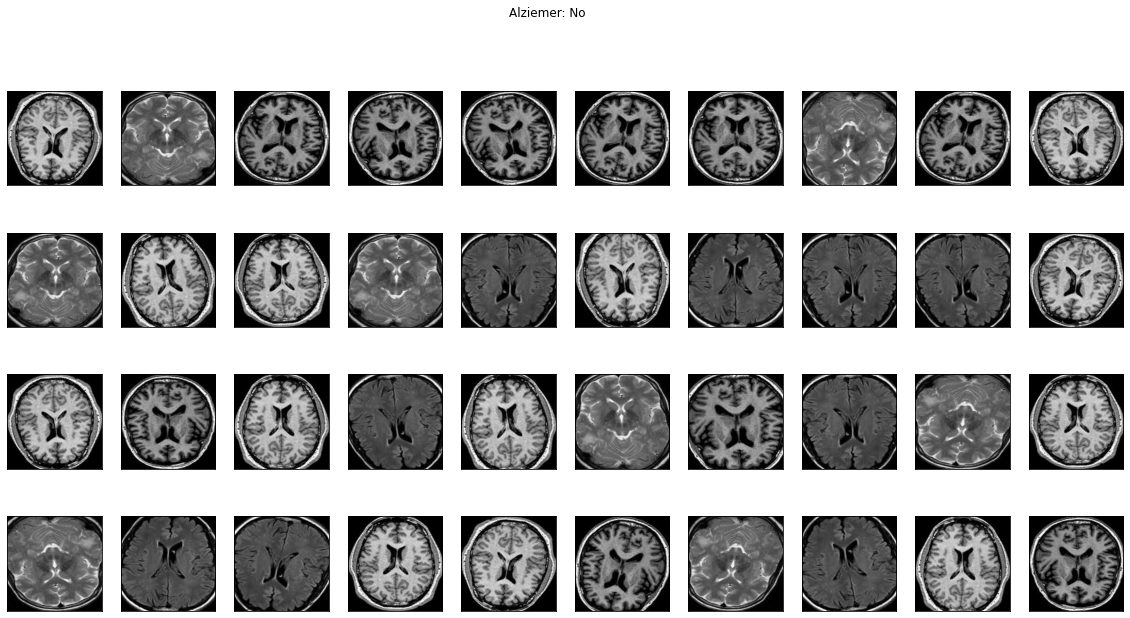

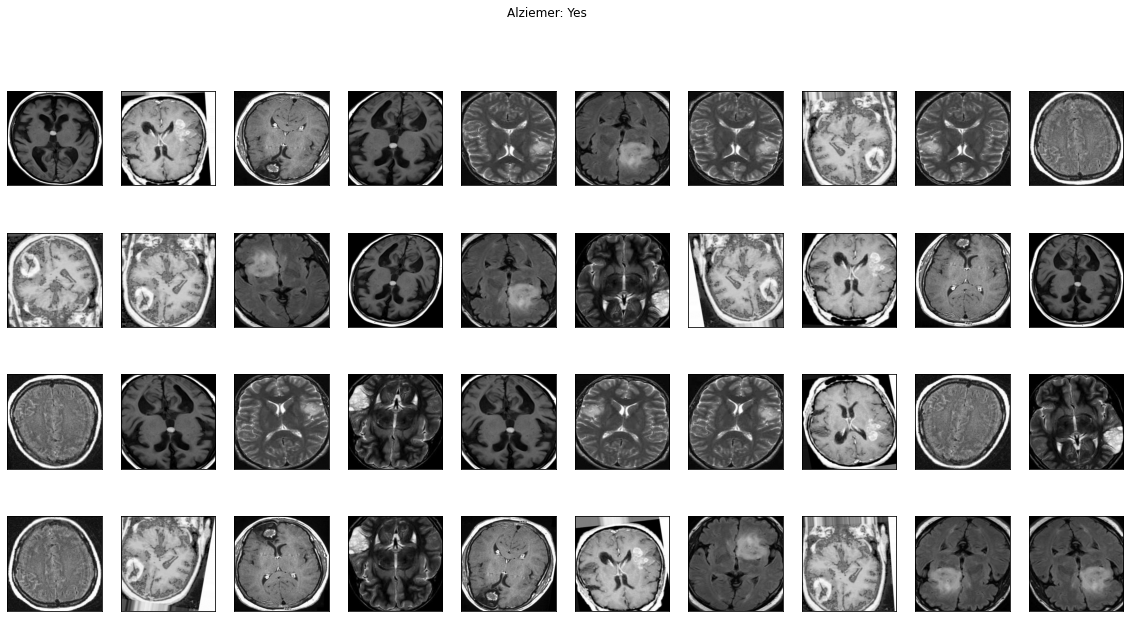

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 266
number of development examples = 57
number of test examples = 57
X_train shape: (266, 240, 240, 3)
Y_train shape: (266, 1)
X_val (dev) shape: (57, 240, 240, 3)
Y_val (dev) shape: (57, 1)
X_test shape: (57, 240, 240, 3)
Y_test shape: (57, 1)


In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Alzheimers_disease_detection')
    
    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "Alzheimers_disease_detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                      

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'Alzheimers_disease_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'/content/drive/MyDrive/AD/logs/{log_file_name}')

In [33]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/content/drive/MyDrive/AD/models{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [34]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0969 - accuracy: 0.9961

9/9 [==============================] - 2s 262ms/step - loss: 0.0962 - accuracy: 0.9962 - val_loss: 0.6672 - val_accuracy: 0.4737
Epoch 2/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9922

9/9 [==============================] - 1s 167ms/step - loss: 0.0862 - accuracy: 0.9925 - val_loss: 0.4786 - val_accuracy: 0.7193
Epoch 3/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0651 - accuracy: 0.9961

9/9 [==============================] - 1s 164ms/step - loss: 0.0643 - accuracy: 0.9962 - val_loss: 0.5110 - val_accuracy: 0.6316
Epoch 4/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0507 - accuracy: 1.0000

9/9 [==============================] - 2s 192ms/step - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.4536 - val_accuracy: 0.7544
Epoch 5/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0454 - accuracy: 1.0000

9/9 [==============================] - 1s 170ms/step - loss: 0.0447 - accuracy: 1.0000 - val_loss: 0.4719 - val_accuracy: 0.7193
Epoch 6/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0384 - accuracy: 1.0000

9/9 [==============================] - 1s 171ms/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.8596
Epoch 7/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0362 - accuracy: 1.0000

9/9 [==============================] - 1s 169ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.3973 - val_accuracy: 0.8421
Epoch 8/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0355 - accuracy: 1.0000

9/9 [==============================] - 1s 165ms/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.3679 - val_accuracy: 0.8947
Epoch 9/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0301 - accuracy: 1.0000

9/9 [==============================] - 2s 261ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.3175 - val_accuracy: 0.9474
Epoch 10/10
8/9 [=========================>....] - ETA: 0s - loss: 0.0263 - accuracy: 1.0000

9/9 [==============================] - 2s 214ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.3255 - val_accuracy: 0.9474
Elapsed time: 0:0:16.7


In [21]:
def load_data1(file_path,image_size):
    
    X2 = []
    
    image_width, image_height = image_size
    print(file_path)
    image = cv2.imread(file_path)
    # crop the brain and ignore the unnecessary rest part of the image
    image = crop_brain_contour(image, plot=False)
    # resize image
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    # image = image / 255.
    # convert image to numpy array and append it to X
    X2.append(image)
    
    X2 = np.array(X2)
    
    print(f'Number of examples is: {len(X2)}')
    print(f'X shape is: {X2.shape}')
    
    return X2

In [22]:
file_path="/content/drive/My Drive/AD/YES/Y11.jpg"
img=load_data1(file_path,(IMG_WIDTH, IMG_HEIGHT))

/content/drive/My Drive/AD/YES/Y11.jpg
Number of examples is: 1
X shape is: (1, 240, 240, 3)


In [23]:
best_model = load_model(filepath='/content/drive/My Drive/AD/models/cnn-parameters-improvement-10-0.62.model')

ss=best_model.predict(img)

print(ss)

if ss[0][0]>0:
    output="Affected"
else:
    output="Not Affected"
        
print(output)

1/1 [==============================] - 0s 119ms/step
[[1.]]
Affected
